# Project 4 Hackathon
## Yan Nusinovich and Shawn Syms
## Goal: Generate Prediction Probabilities of Wage Being Over 50K

In [1]:
# The usual suspects
import numpy as np
import pandas as pd
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# sci-kit learn
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import ElasticNet, ElasticNetCV, Lasso, LassoCV, LinearRegression, LogisticRegression, Ridge, RidgeCV
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from category_encoders.target_encoder import TargetEncoder

# Presentation
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 25000)
pd.set_option('display.max_rows', 600)

# Read in Data

In [2]:
df = pd.read_csv("data/large_train_sample.csv")
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,wage
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,40,Cuba,<=50K


In [3]:
df['workclass'].value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64

In [4]:
df['occupation'].value_counts()

 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 ?                    1843
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: occupation, dtype: int64

In [5]:
df['native-country'].value_counts()

 United-States                 29170
 Mexico                          643
 ?                               583
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 

In [6]:
df[df["native-country"].str.contains("Holand-Netherlands", regex = False) == True]
df.loc[19609,"native-country"] = " ?"

In [7]:
df['native-country'].value_counts()

 United-States                 29170
 Mexico                          643
 ?                               584
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 

In [8]:
df.drop(columns = ['education'], inplace = True)

In [9]:
categorical_features = ['marital-status', 'relationship', 'sex']

le_knn_list = []
for column in categorical_features:
    le = LabelEncoder()
    le.fit(df[column])
    le_knn_list.append(le)
    df[column] = le.transform(df[column])

In [10]:
df_native_country_missing = df[df["native-country"].str.contains("?", regex = False) == True]
df_native_country_nonmissing = df[~df["native-country"].str.contains("?", case = False, regex = False) == True]
df_occupation_missing = df[df["occupation"].str.contains("?", regex = False) == True]
df_occupation_nonmissing = df[~df["occupation"].str.contains("?", case = False, regex = False) == True]
df_workclass_missing = df[df["workclass"].str.contains("?", regex = False) == True]
df_workclass_nonmissing = df[~df["workclass"].str.contains("?", case = False, regex = False) == True]

# Fill in Missing Values with KNN

#### Fill in Native Country:

In [11]:
# rows of dataframe with no ?
X = df_native_country_nonmissing.drop(columns = ["native-country", "occupation", "workclass", "wage"])
y = df_native_country_nonmissing["native-country"]

# rows of dataframe with ?
X_test = df_native_country_missing.drop(columns = ["native-country", "occupation", "workclass", "wage"])

In [12]:
pipe_knn_nc = Pipeline([("knn", KNeighborsClassifier())])
pipe_knn_nc_params = {"knn__n_neighbors": [15]}
gs_knn_nc = GridSearchCV(pipe_knn_nc,
                           param_grid = pipe_knn_nc_params,
                           cv = 5, n_jobs = -1)
gs_knn_nc.fit(X, y)
gs_knn_nc_model = gs_knn_nc.best_estimator_
gs_knn_nc.best_params_

{'knn__n_neighbors': 15}

In [13]:
df.loc[df["native-country"].str.contains("?", regex = False) == True, "native-country"] = gs_knn_nc_model.predict(X_test)

In [14]:
df.loc[df["native-country"].str.contains("?", regex = False) == True, "native-country"]

Series([], Name: native-country, dtype: object)

#### Fill in Workclass:

In [15]:
# rows of dataframe with no ?
X = df_workclass_nonmissing.drop(columns = ["native-country", "occupation", "workclass", "wage"])
y = df_workclass_nonmissing["workclass"]

# rows of dataframe with ?
X_test = df_workclass_missing.drop(columns = ["native-country", "occupation", "workclass", "wage"])

In [16]:
pipe_knn_wc = Pipeline([("knn", KNeighborsClassifier())])
pipe_knn_wc_params = {"knn__n_neighbors": [17]}
gs_knn_wc = GridSearchCV(pipe_knn_wc,
                           param_grid = pipe_knn_wc_params,
                           cv = 5, n_jobs = -1)
gs_knn_wc.fit(X, y)
gs_knn_wc_model = gs_knn_wc.best_estimator_
gs_knn_wc.best_params_

{'knn__n_neighbors': 17}

In [17]:
df.loc[df["workclass"].str.contains("?", regex = False) == True, "workclass"] = gs_knn_wc_model.predict(X_test)

In [18]:
df.loc[df["workclass"].str.contains("?", regex = False) == True, "workclass"]

Series([], Name: workclass, dtype: object)

#### Fill in Occupation:

In [19]:
# rows of dataframe with no ?
X = df_occupation_nonmissing.drop(columns = ["native-country", "occupation", "workclass", "wage"])
y = df_occupation_nonmissing["occupation"]

# rows of dataframe with ?
X_test = df_occupation_missing.drop(columns = ["native-country", "occupation", "workclass", "wage"])

In [20]:
pipe_knn_occ = Pipeline([("knn", KNeighborsClassifier())])
pipe_knn_occ_params = {"knn__n_neighbors": [16]}
gs_knn_occ = GridSearchCV(pipe_knn_occ,
                           param_grid = pipe_knn_occ_params,
                           cv = 5, n_jobs = -1)
gs_knn_occ.fit(X, y)
gs_knn_occ_model = gs_knn_occ.best_estimator_
gs_knn_occ.best_params_

{'knn__n_neighbors': 16}

In [21]:
df.loc[df["occupation"].str.contains("?", regex = False) == True, "occupation"] = gs_knn_occ_model.predict(X_test)

In [22]:
df.loc[df["occupation"].str.contains("?", regex = False) == True, "occupation"]

Series([], Name: occupation, dtype: object)

# Do Target Encoding

In [23]:
lb = LabelBinarizer()
df['wage'] = lb.fit_transform(df['wage'])

In [24]:
for i in range(0,len(categorical_features)):
    df[categorical_features[i]] = le_knn_list[i].inverse_transform(df[categorical_features[i]])

In [26]:
categorical_features_remaining = ['workclass', 'occupation', 'native-country', "marital-status", "relationship", "sex"]

te_remaining_list = []
for column in categorical_features_remaining:
    te = TargetEncoder()
    te.fit(df[column], df['wage'])
    te_remaining_list.append(te)
    df[column] = te.transform(df[column])

In [27]:
df.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,wage
0,39,0.271957,77516,13,0.045961,0.128175,0.103070,0.305737,2174,0,40,0.245917,0
1,50,0.285208,83311,13,0.446848,0.463470,0.448571,0.305737,0,0,13,0.245917,0
2,38,0.210061,215646,9,0.104209,0.062455,0.103070,0.305737,0,0,40,0.245917,0
3,53,0.210061,234721,7,0.446848,0.062455,0.448571,0.305737,0,0,40,0.245917,0
4,28,0.210061,338409,13,0.446848,0.434963,0.475128,0.109461,0,0,40,0.263158,0


# Visualization

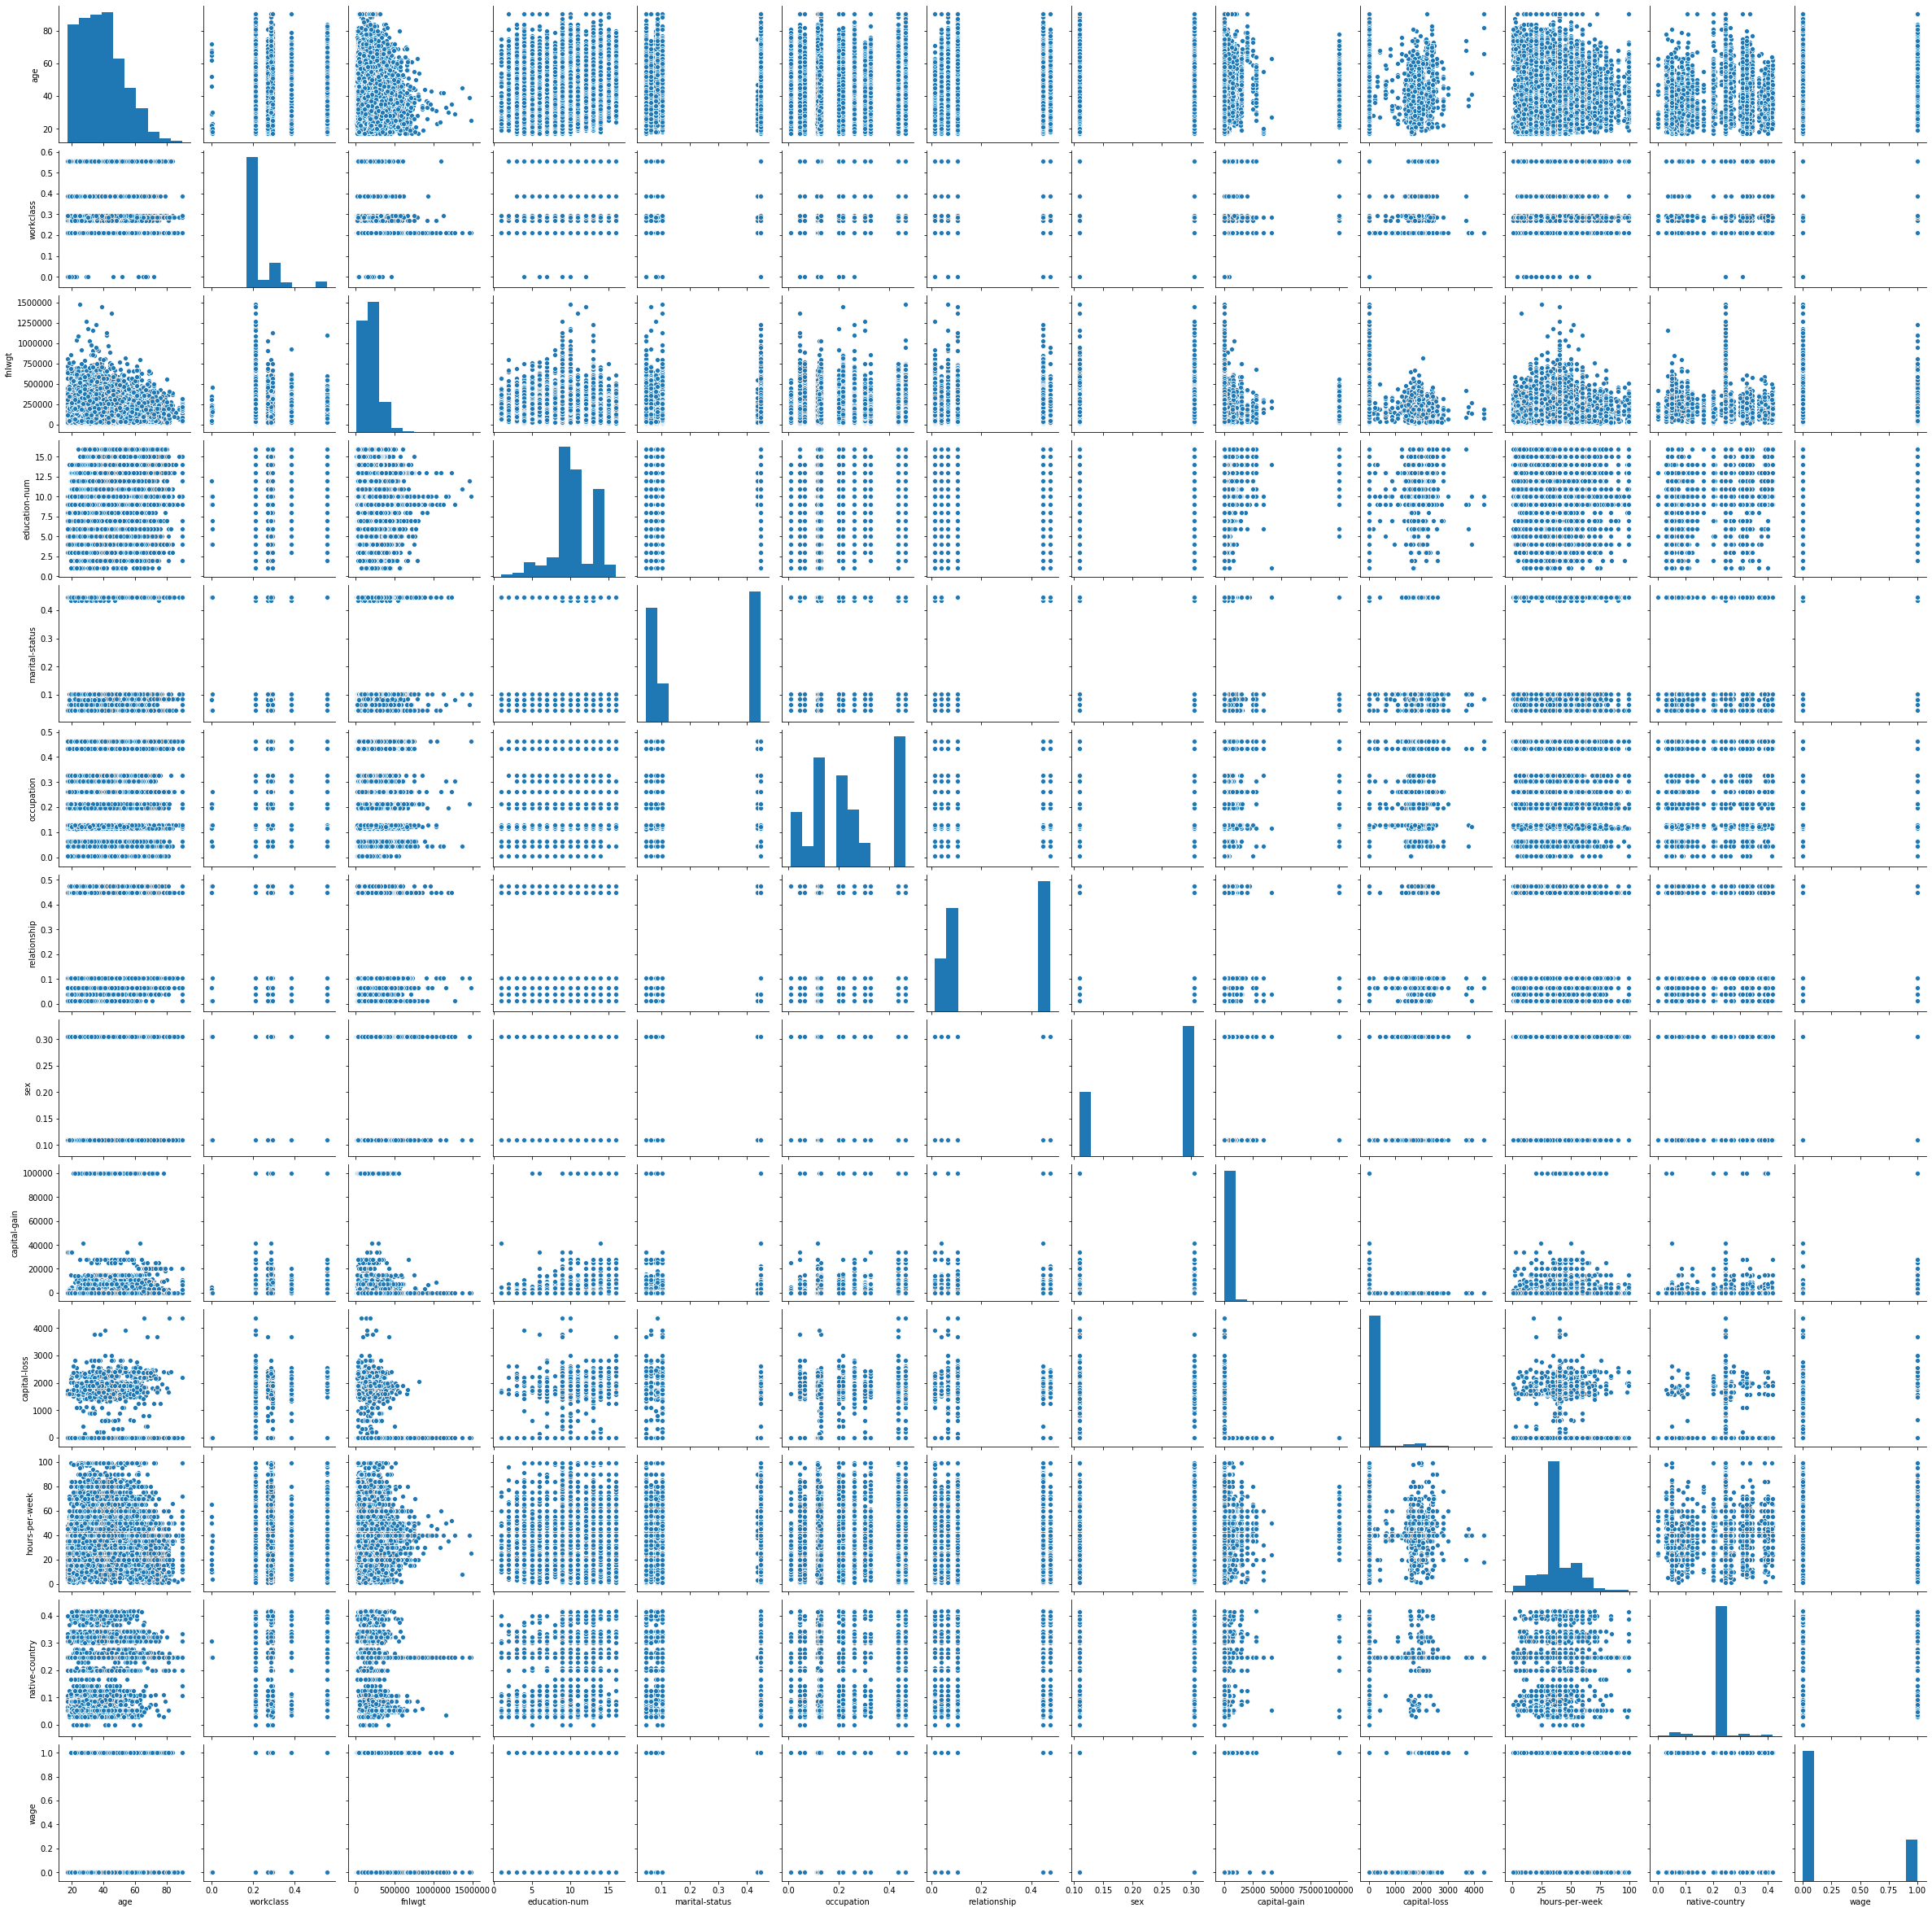

In [28]:
sns.pairplot(df)

In [29]:
df.corr()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,wage
age,1.000000,0.169187,-0.076646,0.036527,0.352616,0.148053,0.359708,0.088832,0.077674,0.057775,0.068756,0.054915,0.234037
workclass,0.169187,1.000000,-0.038369,0.144198,0.142217,0.178246,0.145369,0.089903,0.087962,0.042502,0.144736,0.047466,0.168476
fnlwgt,-0.076646,-0.038369,1.000000,-0.043195,-0.029502,-0.025605,-0.029497,0.026858,0.000432,-0.010252,-0.018768,-0.118423,-0.009463
education-num,0.036527,0.144198,-0.043195,1.000000,0.085078,0.470170,0.108158,0.012280,0.122630,0.079923,0.148123,0.242551,0.335154
marital-status,0.352616,0.142217,-0.029502,0.085078,1.000000,0.181608,0.970912,0.416893,0.086806,0.080877,0.220834,0.033445,0.447404
occupation,0.148053,0.178246,-0.025605,0.470170,0.181608,1.000000,0.196991,0.082991,0.112637,0.086507,0.176998,0.125498,0.338835
relationship,0.359708,0.145369,-0.029497,0.108158,0.970912,0.196991,1.000000,0.416021,0.089331,0.084991,0.235564,0.037276,0.453585
sex,0.088832,0.089903,0.026858,0.012280,0.416893,0.082991,0.416021,1.000000,0.048480,0.045567,0.229309,0.003662,0.215980
capital-gain,0.077674,0.087962,0.000432,0.122630,0.086806,0.112637,0.089331,0.048480,1.000000,-0.031615,0.078409,0.022764,0.223329
capital-loss,0.057775,0.042502,-0.010252,0.079923,0.080877,0.086507,0.084991,0.045567,-0.031615,1.000000,0.054256,0.026432,0.150526


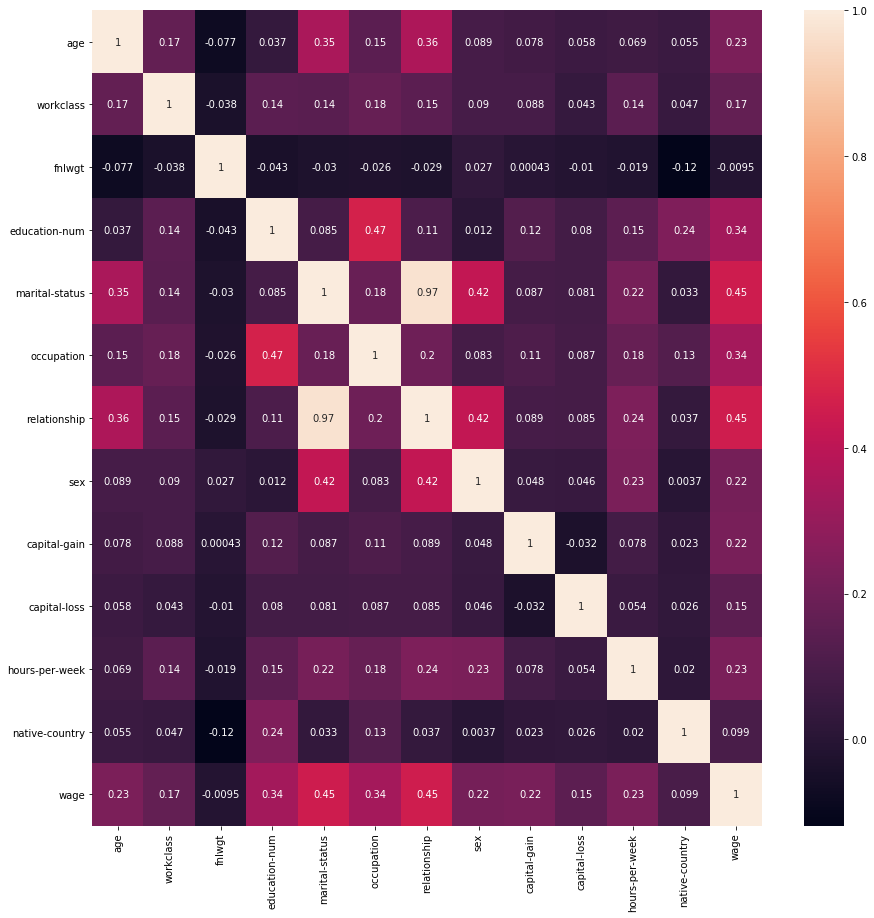

In [30]:
# Create and review a correlations heatmap
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot=True, annot_kws={"size": 10})

# Modeling

In [31]:
X = df.drop(columns = "wage")

In [32]:
y = df["wage"]

In [34]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

# X_train.to_csv("data/X_train", index = False)
# X_test.to_csv("data/X_test", index = False)
# y_train.to_csv("data/y_train", index = False)
# y_test.to_csv("data/y_test", index = False)

X_train = pd.read_csv("data/X_train", squeeze = True)
X_test = pd.read_csv("data/X_test", squeeze = True)
y_train = pd.read_csv("data/y_train", squeeze = True)
y_test = pd.read_csv("data/y_test", squeeze = True)

In [35]:
pipe_knn = Pipeline([('sc', StandardScaler()),
                     ("knn", KNeighborsClassifier())])
pipe_knn_params = {"knn__n_neighbors": [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
                   "knn__weights": ["distance"],
                   "knn__p": [1]}
pipe_knn_gridsearch = GridSearchCV(pipe_knn,
                                   param_grid = pipe_knn_params,
                                   cv = 5,
                                   verbose = 0,
                                   n_jobs = -1)
pipe_knn_gridsearch.fit(X_train, y_train)
pipe_knn_final = pipe_knn_gridsearch.best_estimator_
print(pipe_knn_gridsearch.best_params_)
print(pipe_knn_final.score(X_train, y_train))
print(pipe_knn_final.score(X_test, y_test))
print(f1_score(y_train, pipe_knn_final.predict(X_train)))
print(f1_score(y_test, pipe_knn_final.predict(X_test)))

{'knn__n_neighbors': 24, 'knn__p': 1, 'knn__weights': 'distance'}
0.9999616093366094
0.8409335175802242
0.9999202869669191
0.634180790960452


In [36]:
pipe_lr = Pipeline([('sc', StandardScaler()),
                    ("lr", LogisticRegression(max_iter = 1000))])
pipe_lr_params = {"lr__penalty": ["l1", "l2", "elasticnet", "none"],
                  "lr__solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
                  'lr__C' : [10, 15, 20, 25, 30, 35, 40]}
pipe_lr_gridsearch = GridSearchCV(pipe_lr,
                                  param_grid = pipe_lr_params,
                                  cv = 5,
                                  verbose = 0,
                                  n_jobs = -1)
pipe_lr_gridsearch.fit(X_train, y_train)
pipe_lr_final = pipe_lr_gridsearch.best_estimator_
print(pipe_lr_gridsearch.best_params_)
print(pipe_lr_final.score(X_train, y_train))
print(pipe_lr_final.score(X_test, y_test))
print(f1_score(y_train, pipe_lr_final.predict(X_train)))
print(f1_score(y_test, pipe_lr_final.predict(X_test)))

{'lr__C': 10, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
0.8485488329238329
0.8447719944725933
0.6515325501280806
0.6380236305048336


In [37]:
pipe_bnb = Pipeline([('sc', StandardScaler()),
                     ("bnb", BernoulliNB())])
pipe_bnb_params = {"bnb__alpha": [150, 175, 200, 225, 250]}
pipe_bnb_gridsearch = GridSearchCV(pipe_bnb,
                                   param_grid = pipe_bnb_params,
                                   cv = 5,
                                   verbose = 0,
                                   n_jobs = -1)
pipe_bnb_gridsearch.fit(X_train, y_train)
pipe_bnb_final = pipe_bnb_gridsearch.best_estimator_
print(pipe_bnb_gridsearch.best_params_)
print(pipe_bnb_final.score(X_train, y_train))
print(pipe_bnb_final.score(X_test, y_test))
print(f1_score(y_train, pipe_bnb_final.predict(X_train)))
print(f1_score(y_test, pipe_bnb_final.predict(X_test)))

{'bnb__alpha': 250}
0.8065494471744472
0.8019345923537541
0.6397368985486522
0.6258700696055685


In [38]:
pipe_mnb = Pipeline([('mms', MinMaxScaler()),
                     ("mnb", MultinomialNB())])
pipe_mnb_params = {"mnb__alpha": [10, 11, 12, 13, 14, 15]}
pipe_mnb_gridsearch = GridSearchCV(pipe_mnb,
                                   param_grid = pipe_mnb_params,
                                   cv = 5,
                                   verbose = 0,
                                   n_jobs = -1)
pipe_mnb_gridsearch.fit(X_train, y_train)
pipe_mnb_final = pipe_mnb_gridsearch.best_estimator_
print(pipe_mnb_gridsearch.best_params_)
print(pipe_mnb_final.score(X_train, y_train))
print(pipe_mnb_final.score(X_test, y_test))
print(f1_score(y_train, pipe_mnb_final.predict(X_train)))
print(f1_score(y_test, pipe_mnb_final.predict(X_test)))


{'mnb__alpha': 10}
0.7641661547911548
0.7633962843543682
0.0412049321055096
0.03385579937304074


In [39]:
pipe_gnb = Pipeline([('sc', StandardScaler()),
                     ("gnb", GaussianNB())])
pipe_gnb_params = {"gnb__var_smoothing": np.logspace(-100,-50,30)}
pipe_gnb_gridsearch = GridSearchCV(pipe_gnb,
                                   param_grid = pipe_gnb_params,
                                   cv = 5,
                                   verbose = 0,
                                   n_jobs = -1)
pipe_gnb_gridsearch.fit(X_train, y_train)
pipe_gnb_final = pipe_gnb_gridsearch.best_estimator_
print(pipe_gnb_gridsearch.best_params_)
print(pipe_gnb_final.score(X_train, y_train))
print(pipe_gnb_final.score(X_test, y_test))
print(f1_score(y_train, pipe_gnb_final.predict(X_train)))
print(f1_score(y_test, pipe_gnb_final.predict(X_test)))


{'gnb__var_smoothing': 1e-100}
0.8300445331695332
0.8254260709350529
0.6035640727142473
0.5911542610571737


In [40]:
pipe_dt = Pipeline([('sc', StandardScaler()),
                    ("dt", DecisionTreeClassifier())])
pipe_dt_params = {"dt__max_depth": [4, 5, 6, 7, 8],
                  "dt__min_samples_split": [10, 11, 12, 13, 14, 15, 16],
                  "dt__min_samples_leaf": [1, 2]}
pipe_dt_gridsearch = GridSearchCV(pipe_dt,
                                  param_grid = pipe_dt_params,
                                  cv = 5,
                                  verbose = 0,
                                  n_jobs = -1)
pipe_dt_gridsearch.fit(X_train, y_train)
pipe_dt_final = pipe_dt_gridsearch.best_estimator_
print(pipe_dt_gridsearch.best_params_)
print(pipe_dt_final.score(X_train, y_train))
print(pipe_dt_final.score(X_test, y_test))
print(f1_score(y_train, pipe_dt_final.predict(X_train)))
print(f1_score(y_test, pipe_dt_final.predict(X_test)))


{'dt__max_depth': 8, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 12}
0.8681280712530712
0.8576692768309535
0.7009142359599477
0.670926517571885


In [41]:
pipe_dt_bag = Pipeline([('sc', StandardScaler()),
                        ("bag", BaggingClassifier(base_estimator = DecisionTreeClassifier()))])
pipe_dt_bag_params = {"bag__base_estimator__max_depth": [9, 11, 13, 15],
                      "bag__base_estimator__min_samples_split": [21, 23, 25, 27],
                      "bag__base_estimator__min_samples_leaf": [2, 3, 4, 5],
                      "bag__n_estimators": [20, 25, 30],
                      "bag__max_samples": [.3, .5, .7],
                      "bag__max_features": [.6, .8, 1]}
pipe_dt_bag_gridsearch = GridSearchCV(pipe_dt_bag,
                                      param_grid = pipe_dt_bag_params,
                                      cv = 5,
                                      verbose = 0,
                                      n_jobs = -1)
pipe_dt_bag_gridsearch.fit(X_train, y_train)
pipe_dt_bag_final = pipe_dt_bag_gridsearch.best_estimator_
print(pipe_dt_bag_gridsearch.best_params_)
print(pipe_dt_bag_final.score(X_train, y_train))
print(pipe_dt_bag_final.score(X_test, y_test))
print(f1_score(y_train, pipe_dt_bag_final.predict(X_train)))
print(f1_score(y_test, pipe_dt_bag_final.predict(X_test)))


{'bag__base_estimator__max_depth': 15, 'bag__base_estimator__min_samples_leaf': 3, 'bag__base_estimator__min_samples_split': 27, 'bag__max_features': 0.8, 'bag__max_samples': 0.7, 'bag__n_estimators': 30}
0.8884751228501229
0.8610471364962383
0.7430795082692138
0.6712677079549583


In [42]:
pipe_rf = Pipeline([('sc', StandardScaler()),
                    ("rf", RandomForestClassifier())])
pipe_rf_params = {"rf__n_estimators": [20, 24, 28, 32],
                  "rf__max_depth": [10, 14, 18],
                  "rf__criterion": ["entropy", "gini"],
                  "rf__min_samples_split": [21, 25, 29],
                  "rf__min_samples_leaf": [2, 3, 4, 5],
                  "rf__max_samples": [.3, .5, .7],
                  "rf__max_features": [.6, .8, 1]}
pipe_rf_gridsearch = GridSearchCV(pipe_rf,
                                  param_grid = pipe_rf_params,
                                  cv = 5,
                                  verbose = 1,
                                  n_jobs = -1)
pipe_rf_gridsearch.fit(X_train, y_train)
pipe_rf_final = pipe_rf_gridsearch.best_estimator_
print(pipe_rf_gridsearch.best_params_)
print(pipe_rf_final.score(X_train, y_train))
print(pipe_rf_final.score(X_test, y_test))
print(f1_score(y_train, pipe_rf_final.predict(X_train)))
print(f1_score(y_test, pipe_rf_final.predict(X_test)))

Fitting 5 folds for each of 2592 candidates, totalling 12960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 6018 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 8418 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 9768 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 11218 tasks      

{'rf__criterion': 'gini', 'rf__max_depth': 18, 'rf__max_features': 0.6, 'rf__max_samples': 0.5, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 25, 'rf__n_estimators': 32}
0.8905866093366094
0.8599723629663749
0.748499823508648
0.6733524355300861


In [43]:
pipe_et = Pipeline([('sc', StandardScaler()),
                    ("et", ExtraTreesClassifier())])
pipe_et_params = {"et__n_estimators": [40, 45, 50, 55],
                  "et__max_depth": [14, 15, 16, 17, 18, 19],
                  "et__criterion": ["entropy", "gini"]}
pipe_et_gridsearch = GridSearchCV(pipe_et,
                                  param_grid = pipe_et_params,
                                  cv = 5,
                                  verbose = 0,
                                  n_jobs = -1)
pipe_et_gridsearch.fit(X_train, y_train)
pipe_et_final = pipe_et_gridsearch.best_estimator_
print(pipe_et_gridsearch.best_params_)
print(pipe_et_final.score(X_train, y_train))
print(pipe_et_final.score(X_test, y_test))
print(f1_score(y_train, pipe_et_final.predict(X_train)))
print(f1_score(y_test, pipe_et_final.predict(X_test)))


{'et__criterion': 'entropy', 'et__max_depth': 18, 'et__n_estimators': 40}
0.9118166461916462
0.8570551205281745
0.7994411944468698
0.6618234653105702


In [44]:
pipe_dt_ada = Pipeline([('sc', StandardScaler()),
                        ("ada", AdaBoostClassifier(base_estimator = DecisionTreeClassifier()))])
pipe_dt_ada_params = {"ada__base_estimator__max_depth": [5],
                      "ada__base_estimator__min_samples_split": [25],
                      "ada__base_estimator__min_samples_leaf": [7],
                      "ada__n_estimators": [13],
                      "ada__learning_rate": [.2, .4, .6]}
pipe_dt_ada_gridsearch = GridSearchCV(pipe_dt_ada,
                                      param_grid = pipe_dt_ada_params,
                                      cv = 5,
                                      verbose = 1,
                                      n_jobs = -1)
pipe_dt_ada_gridsearch.fit(X_train, y_train)
pipe_dt_ada_final = pipe_dt_ada_gridsearch.best_estimator_
print(pipe_dt_ada_gridsearch.best_params_)
print(pipe_dt_ada_final.score(X_train, y_train))
print(pipe_dt_ada_final.score(X_test, y_test))
print(f1_score(y_train, pipe_dt_ada_final.predict(X_train)))
print(f1_score(y_test, pipe_dt_ada_final.predict(X_test)))


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.9s finished


{'ada__base_estimator__max_depth': 5, 'ada__base_estimator__min_samples_leaf': 7, 'ada__base_estimator__min_samples_split': 25, 'ada__learning_rate': 0.6, 'ada__n_estimators': 13}
0.878877457002457
0.8661139259941655
0.728555450400069
0.6936050597329585


In [45]:
pipe_svc = Pipeline([('sc', StandardScaler()),
                     ("svc", SVC())])
pipe_svc_params = {"svc__C": [.1, .5, 1, 1.3, 1.5],
                   "svc__gamma": ["scale", "auto", 0.1, 0.3, 0.5], 
                   "svc__kernel": ["rbf"]}
pipe_svc_gridsearch = GridSearchCV(pipe_svc,
                                   param_grid = pipe_svc_params,
                                   cv = 5,
                                   verbose = 1,
                                   n_jobs = -1)
pipe_svc_gridsearch.fit(X_train, y_train)
pipe_svc_final = pipe_svc_gridsearch.best_estimator_
print(pipe_svc_gridsearch.best_params_)
print(pipe_svc_final.score(X_train, y_train))
print(pipe_svc_final.score(X_test, y_test))
print(f1_score(y_train, pipe_svc_final.predict(X_train)))
print(f1_score(y_test, pipe_svc_final.predict(X_test)))


Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  3.7min finished


{'svc__C': 1.5, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
0.8642506142506142
0.8489175495163519
0.6818999640158331
0.6403508771929824


# Pass in the test data

In [49]:
df_test = pd.read_csv('data/test_data.csv')

In [50]:
df_test.drop(columns=['education'], inplace = True)

In [51]:
categorical_features = ['marital-status', 'relationship', 'sex']

for i in range(0, len(categorical_features)):
    df_test[categorical_features[i]] = le_knn_list[i].transform(df_test[categorical_features[i]])

In [52]:
df_native_country_missing = df_test[df_test["native-country"].str.contains("?", regex = False) == True]
df_native_country_nonmissing = df_test[~df_test["native-country"].str.contains("?", case = False, regex = False) == True]
df_occupation_missing = df_test[df_test["occupation"].str.contains("?", regex = False) == True]
df_occupation_nonmissing = df_test[~df_test["occupation"].str.contains("?", case = False, regex = False) == True]
df_workclass_missing = df_test[df_test["workclass"].str.contains("?", regex = False) == True]
df_workclass_nonmissing = df_test[~df_test["workclass"].str.contains("?", case = False, regex = False) == True]

#### Fill in Native Country:

In [53]:
X_test = df_native_country_missing.drop(columns = ["native-country", "occupation", "workclass"])

In [54]:
df_test.loc[df_test["native-country"].str.contains("?", regex = False) == True, "native-country"] = gs_knn_nc_model.predict(X_test)

In [55]:
df_test.loc[df_test["native-country"].str.contains("?", regex = False) == True, "native-country"]

Series([], Name: native-country, dtype: object)

#### Fill in Workclass:

In [56]:
X_test = df_workclass_missing.drop(columns = ["native-country", "occupation", "workclass"])

In [57]:
df_test.loc[df_test["workclass"].str.contains("?", regex = False) == True, "workclass"] = gs_knn_wc_model.predict(X_test)

In [58]:
df_test.loc[df_test["workclass"].str.contains("?", regex = False) == True, "workclass"]

Series([], Name: workclass, dtype: object)

#### Fill in Occupation:

In [59]:
X_test = df_occupation_missing.drop(columns = ["native-country", "occupation", "workclass"])

In [60]:
df_test.loc[df_test["occupation"].str.contains("?", regex = False) == True, "occupation"] = gs_knn_occ_model.predict(X_test)

In [61]:
df_test.loc[df_test["occupation"].str.contains("?", regex = False) == True, "occupation"]

Series([], Name: occupation, dtype: object)

In [62]:
df_test

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,226802,7,4,Machine-op-inspct,3,1,0,0,40,United-States
1,38,Private,89814,9,2,Farming-fishing,0,1,0,0,50,United-States
2,28,Local-gov,336951,12,2,Protective-serv,0,1,0,0,40,United-States
3,44,Private,160323,10,2,Machine-op-inspct,0,1,7688,0,40,United-States
4,18,Private,103497,10,4,Adm-clerical,3,0,0,0,30,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419,13,0,Prof-specialty,1,0,0,0,36,United-States
16277,64,Private,321403,9,6,Adm-clerical,2,1,0,0,40,United-States
16278,38,Private,374983,13,2,Prof-specialty,0,1,0,0,50,United-States
16279,44,Private,83891,13,0,Adm-clerical,3,1,5455,0,40,United-States


In [63]:
for i in range(0,len(categorical_features)):
    df_test[categorical_features[i]] = le_knn_list[i].inverse_transform(df_test[categorical_features[i]])

In [64]:
categorical_features_remaining = ['workclass', 'occupation', 'native-country', 'marital-status', 'relationship', 'sex']

for i in range(0,len(categorical_features_remaining)):
    df_test[categorical_features_remaining[i]] = te_remaining_list[i].transform(df_test[categorical_features_remaining[i]])


In [65]:
df_test

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,0.210061,226802,7,0.045961,0.122875,0.013220,0.305737,0,0,40,0.245917
1,38,0.210061,89814,9,0.446848,0.115044,0.448571,0.305737,0,0,50,0.245917
2,28,0.294792,336951,12,0.446848,0.325653,0.448571,0.305737,0,0,40,0.245917
3,44,0.210061,160323,10,0.446848,0.122875,0.448571,0.305737,7688,0,40,0.245917
4,18,0.210061,103497,10,0.045961,0.128175,0.013220,0.109461,0,0,30,0.245917
...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,0.210061,215419,13,0.104209,0.434963,0.103070,0.109461,0,0,36,0.245917
16277,64,0.210061,321403,9,0.085599,0.128175,0.037717,0.305737,0,0,40,0.245917
16278,38,0.210061,374983,13,0.446848,0.434963,0.448571,0.305737,0,0,50,0.245917
16279,44,0.210061,83891,13,0.104209,0.128175,0.013220,0.305737,5455,0,40,0.245917


In [66]:
predictions = pipe_dt_ada_final.predict_proba(df_test)

In [67]:
positive_predictions = []

for prediction in predictions:
    positive_predictions.append(prediction[1])
    
positive_predictions

[0.25101757571756017,
 0.4544292869608883,
 0.4708624172818319,
 0.935269625486101,
 0.007808242143159284,
 0.2480886938849047,
 0.3015930504154222,
 0.5839008875100039,
 0.2620684075144322,
 0.037393536645993534,
 0.5561362342873962,
 0.5171406089276727,
 0.27109689620774036,
 0.4355265114523966,
 0.7513922243248048,
 0.5629119781141346,
 0.0003965327907810828,
 0.48467576229103565,
 0.2615472059799728,
 0.5393678331863022,
 0.5227797264576524,
 0.25093767565359665,
 0.03204857031338131,
 0.41455465014216064,
 0.5118604965762313,
 0.9349828044879701,
 0.008518217104868584,
 0.16261642271771035,
 0.4519919454673831,
 0.4527341509853671,
 0.9378085756812649,
 0.38924341002018137,
 0.39486957382582044,
 0.3797014540146055,
 0.3085760926661521,
 0.4708009312899867,
 0.5101851137317099,
 0.4047952950475506,
 0.008789697265021207,
 0.009949068262400383,
 0.5439123332217033,
 0.521543985453874,
 0.43275684132008685,
 0.3946679990101242,
 0.008163423353436382,
 0.49520323704067504,
 0.4049977

In [68]:
positive_predictions_series = pd.DataFrame(positive_predictions, columns = ["wage"], index = df_test.index)
positive_predictions_series

,wage
0,0.251018
1,0.454429
2,0.470862
3,0.935270
4,0.007808
...,...
16276,0.440504
16277,0.399588
16278,0.547376
16279,0.417644


In [69]:
positive_predictions_series.to_csv("data/predictions.csv", index = False)